In [1]:
import numpy as np
import matplotlib.pyplot as plt
import HUXt as H
import astropy.units as u
%matplotlib inline

In [2]:
# Create a the inner boundary solar wind condition (this must be 128 in size)
v_boundary = np.ones(128) * 400 * u.km/u.s
# Add two fast streams
v_boundary[10:20] = v_boundary[10:20] * 2.0
v_boundary[60:80] = v_boundary[60:80] * 1.8

# Get a list of different CMEs with random launch longitudes and times
cme_list=[]
launch_lons = np.random.rand(5) * 360
daysec = 86400
launch_times = 0.25  + np.random.rand(5) * 3.5 * daysec
for lon, t_launch in zip(launch_lons, launch_times):
    cme = H.ConeCME(t_launch=t_launch, longitude=lon, width=30, v=1000, thickness=10)
    cme_list.append(cme)

# Set up HUXt to run a simulation for 5 days, and output model data every 4 timesteps (about 35min)
cone_model = H.HUXt2D(simtime=5, dt_scale=4)
# Run the model, with a tag to go on output filename
tag = ""
cone_model.solve(v_boundary, cme_list, save=False, tag=tag) 
# Make an MP4 of the solution with CME
output_tag = "test_cone_run".format(lon)
cone_model.animate('cme', output_tag)



Moviepy - Building video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_test_cone_run_movie.mp4.
Moviepy - Writing video C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_test_cone_run_movie.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\yq904481\research\repos\HUXt\figures\HUXt2D\HUXt2D_test_cone_run_movie.mp4


(<Figure size 1008x1008 with 2 Axes>,
 <matplotlib.axes._subplots.PolarAxesSubplot at 0x20da4f45470>)

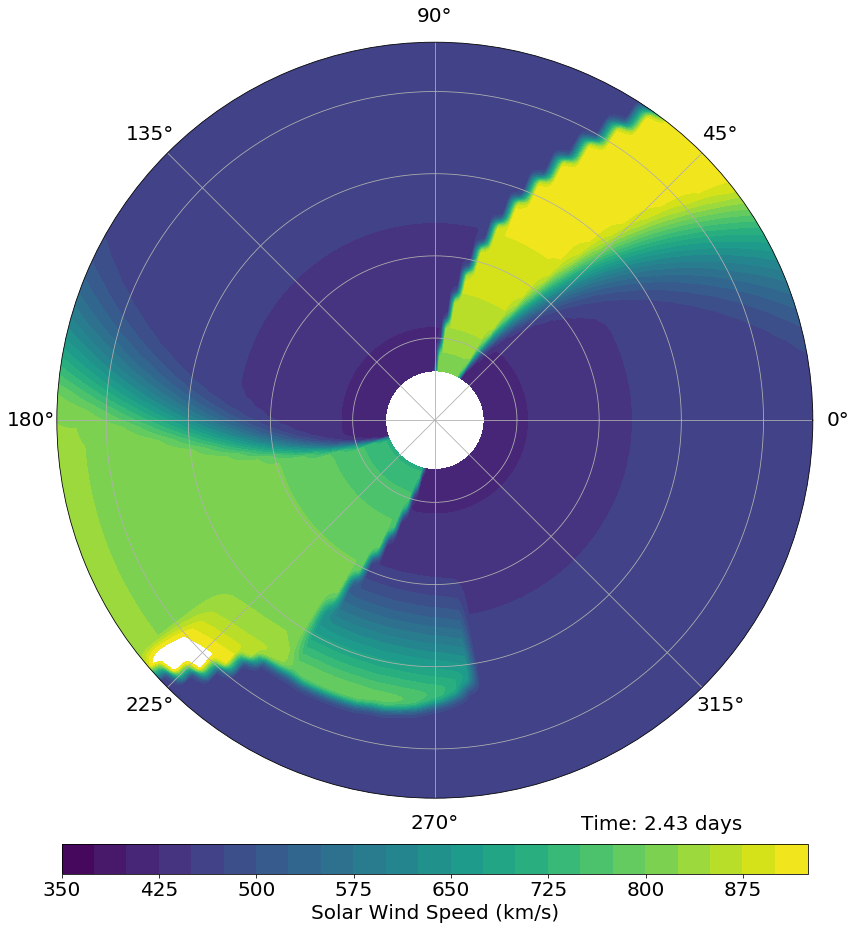

In [3]:
# Output a plot of the model output at the 100th timestep
cone_model.plot(100)